# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold

from tensorflow import keras
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from keras.models import Sequential
from keras_tuner.tuners import RandomSearch
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

import warnings
warnings.filterwarnings('ignore')

# Import Dataset

In [3]:
df = pd.read_csv('/content/gas_turbines.csv')
df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


# Data Exploration

In [4]:
df.shape

(15039, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [6]:
df.describe()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,15039.000000,15039.00000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000
mean,17.764381,1013.19924,79.124174,4.200294,25.419061,1083.798770,545.396183,134.188464,12.102353,1.972499,68.190934
std,7.574323,6.41076,13.793439,0.760197,4.173916,16.527806,7.866803,15.829717,1.103196,2.222206,10.470586
min,0.522300,985.85000,30.344000,2.087400,17.878000,1000.800000,512.450000,100.170000,9.904400,0.000388,27.765000
25%,11.408000,1008.90000,69.750000,3.723900,23.294000,1079.600000,542.170000,127.985000,11.622000,0.858055,61.303500
50%,18.186000,1012.80000,82.266000,4.186200,25.082000,1088.700000,549.890000,133.780000,12.025000,1.390200,66.601000
75%,23.862500,1016.90000,90.043500,4.550900,27.184000,1096.000000,550.060000,140.895000,12.578000,2.160400,73.935500
max,34.929000,1034.20000,100.200000,7.610600,37.402000,1100.800000,550.610000,174.610000,15.081000,44.103000,119.890000


In [7]:
df.nunique()

AT      12086
AP        540
AH      12637
AFDP    11314
GTEP     8234
TIT       706
TAT      2340
TEY      4207
CDP      3611
CO      13096
NOX     11996
dtype: int64

# Checking missing value

In [8]:
df.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

# Correlation Analysis

<Axes: >

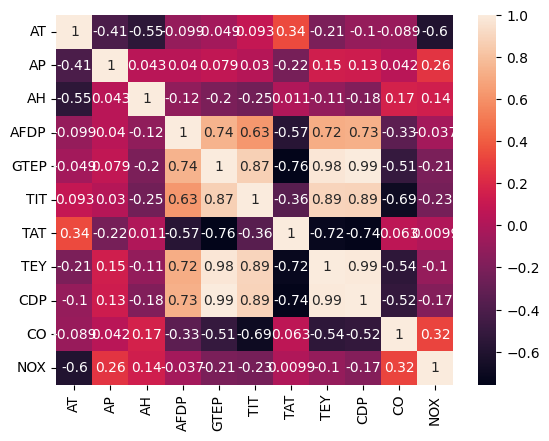

In [9]:
sns.heatmap(df.corr(),annot=True)

In [10]:
numerical_features = df.describe(include=["int64","float64"]).columns
numerical_features

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')

# Data Visualization

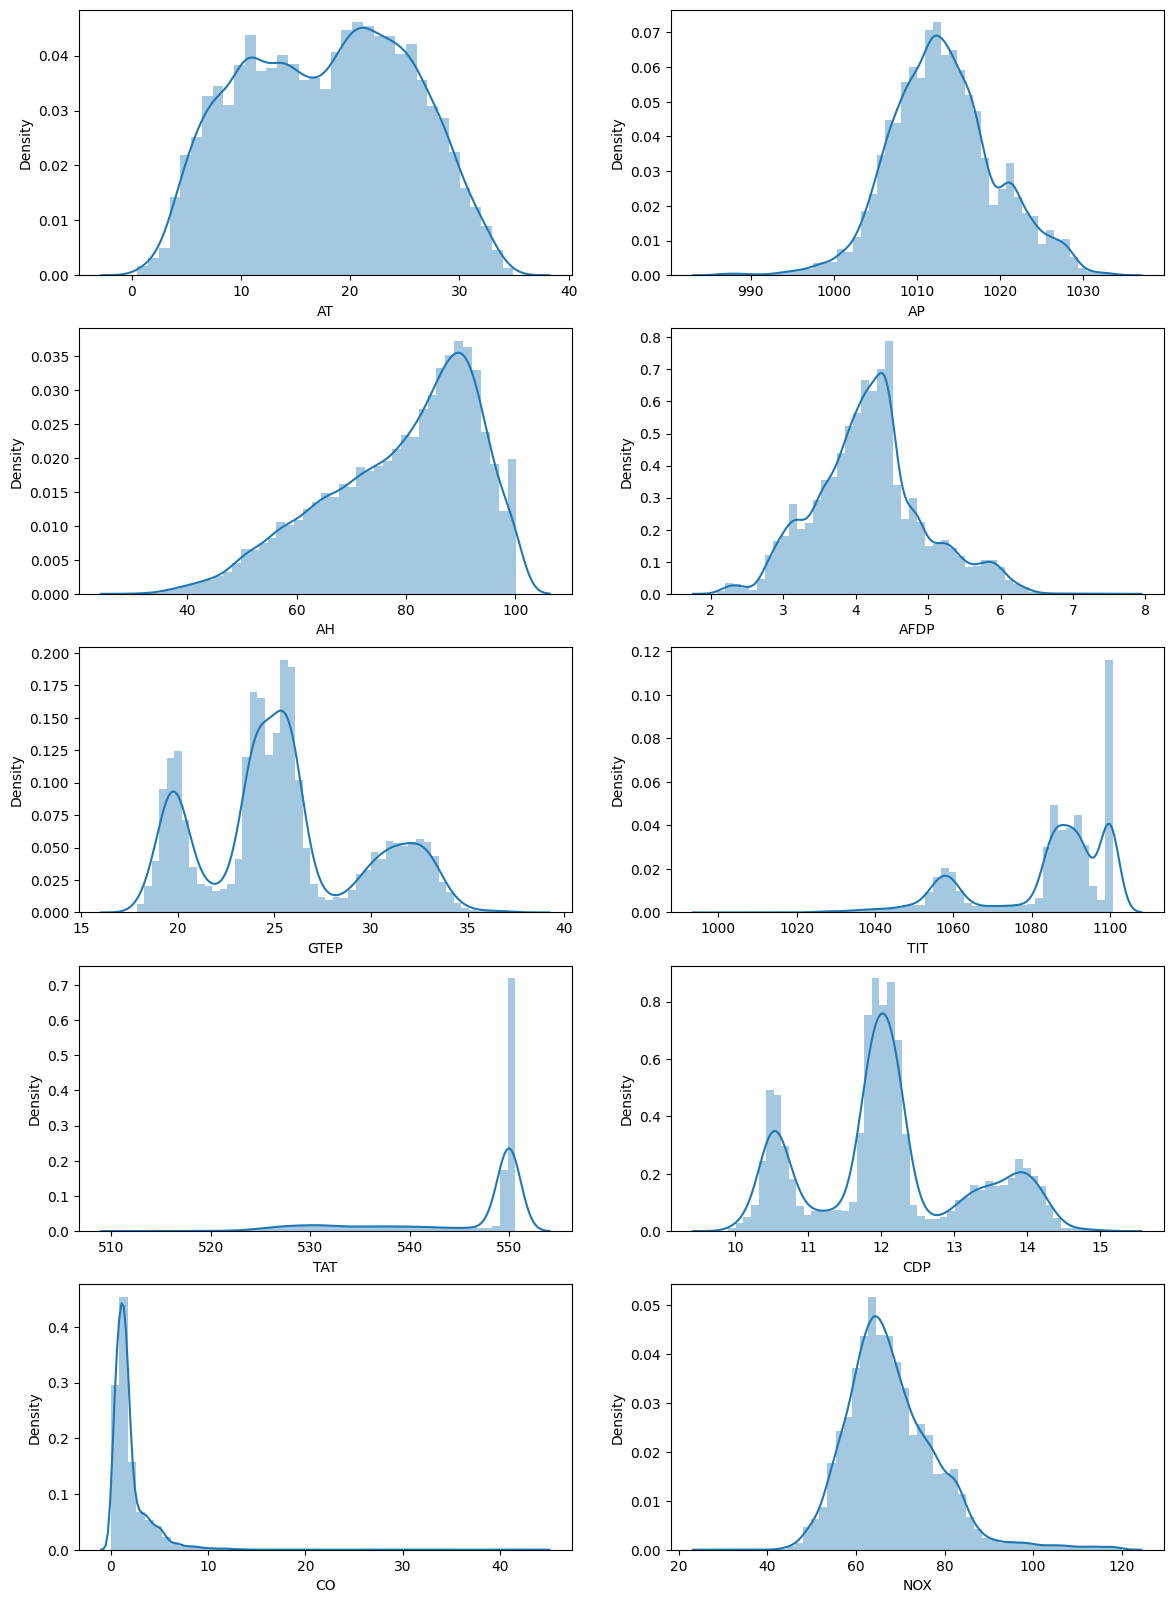

In [11]:
# Data Visualization
fig, ax = plt.subplots(5,2, figsize = (14,20))

sns.distplot(df.AT, ax = ax[0,0])
sns.distplot(df.AP, ax = ax[0,1])
sns.distplot(df.AH, ax = ax[1,0])
sns.distplot(df.AFDP, ax = ax[1,1])
sns.distplot(df.GTEP, ax = ax[2,0])
sns.distplot(df.TIT, ax = ax[2,1])
sns.distplot(df.TAT, ax = ax[3,0])
sns.distplot(df.CDP, ax = ax[3,1])
sns.distplot(df.CO, ax = ax[4,0])
sns.distplot(df.NOX, ax = ax[4,1])

plt.show()

# Outliers Detection

In [12]:
# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers.
    """
    outlier_indices = []

    for col in df.columns.tolist():         # iterate over features(columns)
        Q1 = np.percentile(df[col],25)      # 1st quartile (25%)
        Q3 = np.percentile(df[col],75)      # 3rd quartile (75%)
        IQR = Q3 - Q1                       # Interquartile rrange (IQR)

        outlier_step = 1.5 * IQR            # outlier step

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

        # Append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # Select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )

    return multiple_outliers

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[numerical_features]))))

The dataset contains 1543 observations with more than 2 outliers


In [13]:
numerical_features

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')

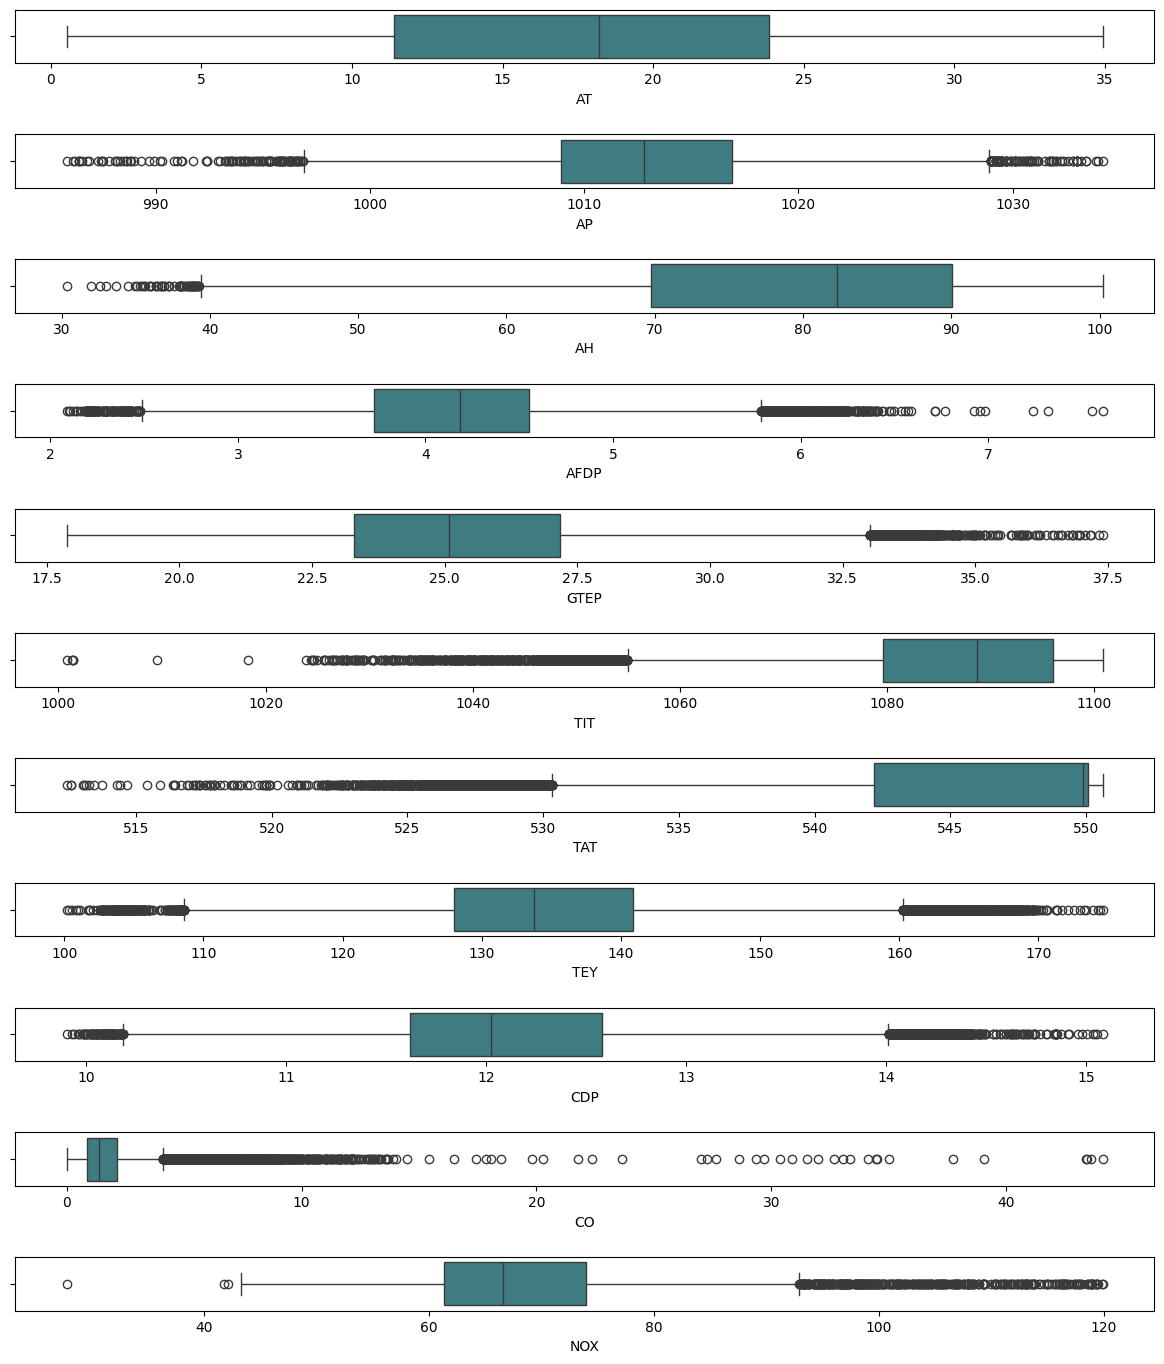

In [14]:
outlier = df.copy()
fig, axes=plt.subplots(11,1,figsize=(12,14),sharex=False,sharey=False)
sns.boxplot(x='AT',data= outlier,palette='crest',ax=axes[0])
sns.boxplot(x='AP',data= outlier,palette='crest',ax=axes[1])
sns.boxplot(x='AH',data= outlier,palette='crest',ax=axes[2])
sns.boxplot(x='AFDP',data= outlier,palette='crest',ax=axes[3])
sns.boxplot(x='GTEP',data= outlier,palette='crest',ax=axes[4])
sns.boxplot(x='TIT',data= outlier,palette='crest',ax=axes[5])
sns.boxplot(x='TAT',data= outlier,palette='crest',ax=axes[6])
sns.boxplot(x='TEY',data= outlier,palette='crest',ax=axes[7])
sns.boxplot(x='CDP',data= outlier,palette='crest',ax=axes[8])
sns.boxplot(x='CO',data= outlier,palette='crest',ax=axes[9])
sns.boxplot(x='NOX',data= outlier,palette='crest',ax=axes[10])
plt.tight_layout(pad=2.0)

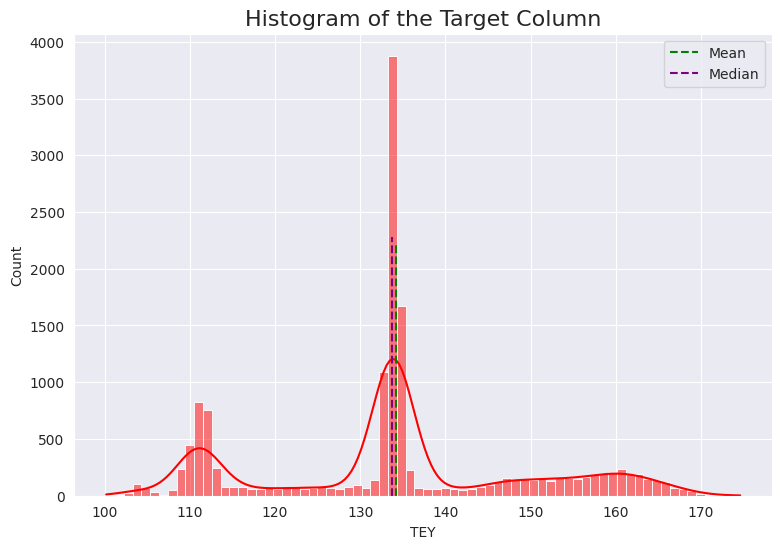

In [15]:
sns.set_style("darkgrid")
plt.figure(figsize=(9,6))
sns.histplot(data= df, x= "TEY", color= "red", kde= True)
plt.axvline(x=df["TEY"].mean(), ymax= 0.55, color= "green", linestyle= '--', label= "Mean")
plt.axvline(x=df["TEY"].median(), ymax= 0.56, color= "purple", linestyle= '--',label= "Median")
plt.title("Histogram of the Target Column", fontsize=16)
plt.legend();

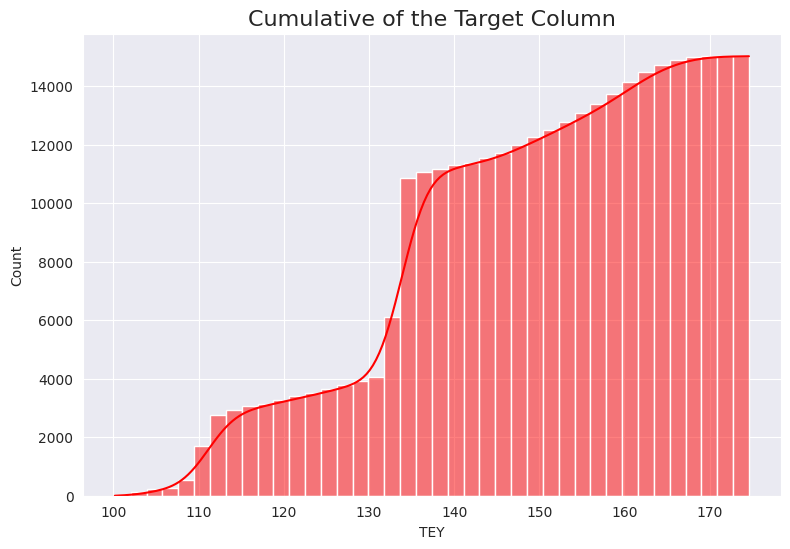

In [16]:
plt.figure(figsize = (9,6))
sns.histplot(df["TEY"], kde= True, bins= 40, color= "red", cumulative= True)
plt.title("Cumulative of the Target Column", fontsize=16);

### Unsurprisingly, Mostly none of the features are on the same scale as we already saw in the previous section

# Multivariate Analysis

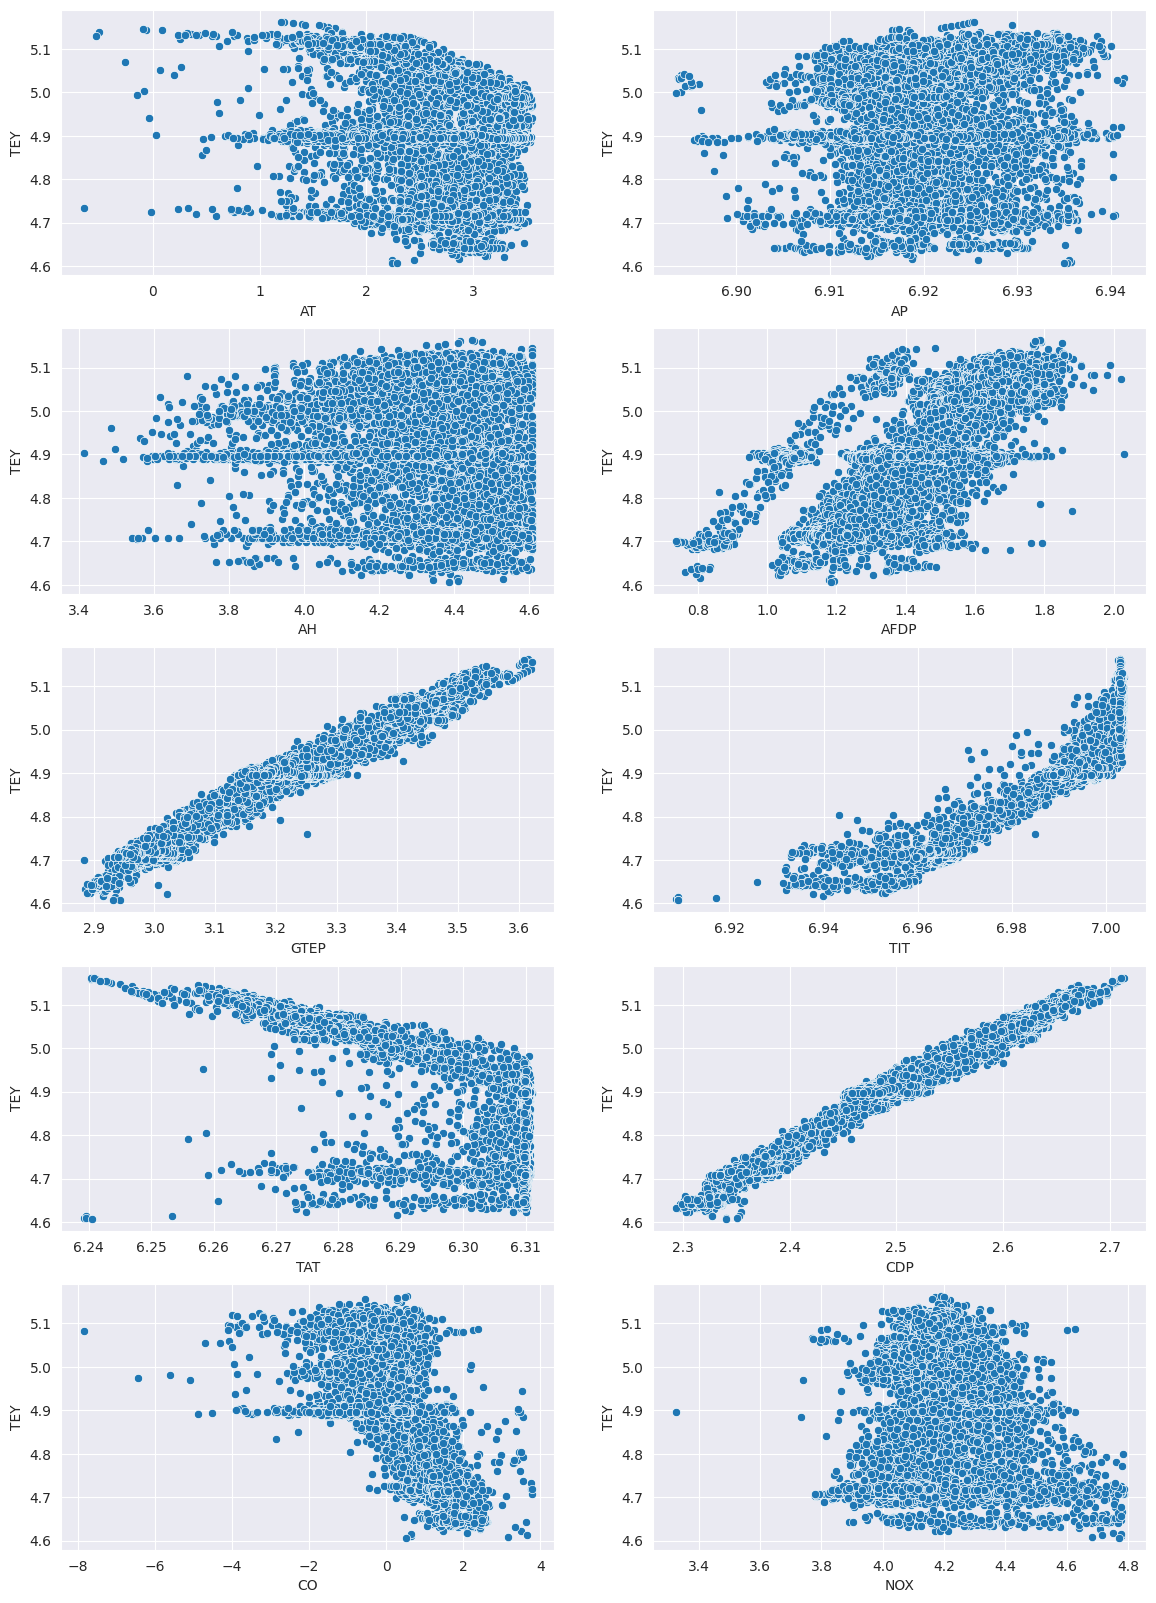

In [17]:
fig, ax = plt.subplots(5,2, figsize = (14,20))

sns.scatterplot(x=np.log(df['AT']), y=np.log(df['TEY']),ax= ax[0,0])
sns.scatterplot(x=np.log(df['AP']), y=np.log(df['TEY']), ax= ax[0,1])
sns.scatterplot(x=np.log(df['AH']), y=np.log(df['TEY']), ax= ax[1,0])
sns.scatterplot(x=np.log(df['AFDP']), y=np.log(df['TEY']),ax= ax[1,1])
sns.scatterplot(x=np.log(df['GTEP']), y=np.log(df['TEY']), ax= ax[2,0])
sns.scatterplot(x=np.log(df['TIT']), y=np.log(df['TEY']), ax= ax[2,1])
sns.scatterplot(x=np.log(df['TAT']), y=np.log(df['TEY']), ax= ax[3,0])
sns.scatterplot(x=np.log(df['CDP']), y=np.log(df['TEY']), ax= ax[3,1])
sns.scatterplot(x=np.log(df['CO']), y=np.log(df['TEY']), ax= ax[4,0])
sns.scatterplot(x=np.log(df['NOX']), y=np.log(df['TEY']), ax= ax[4,1])

plt.show()

<Figure size 2000x2000 with 0 Axes>

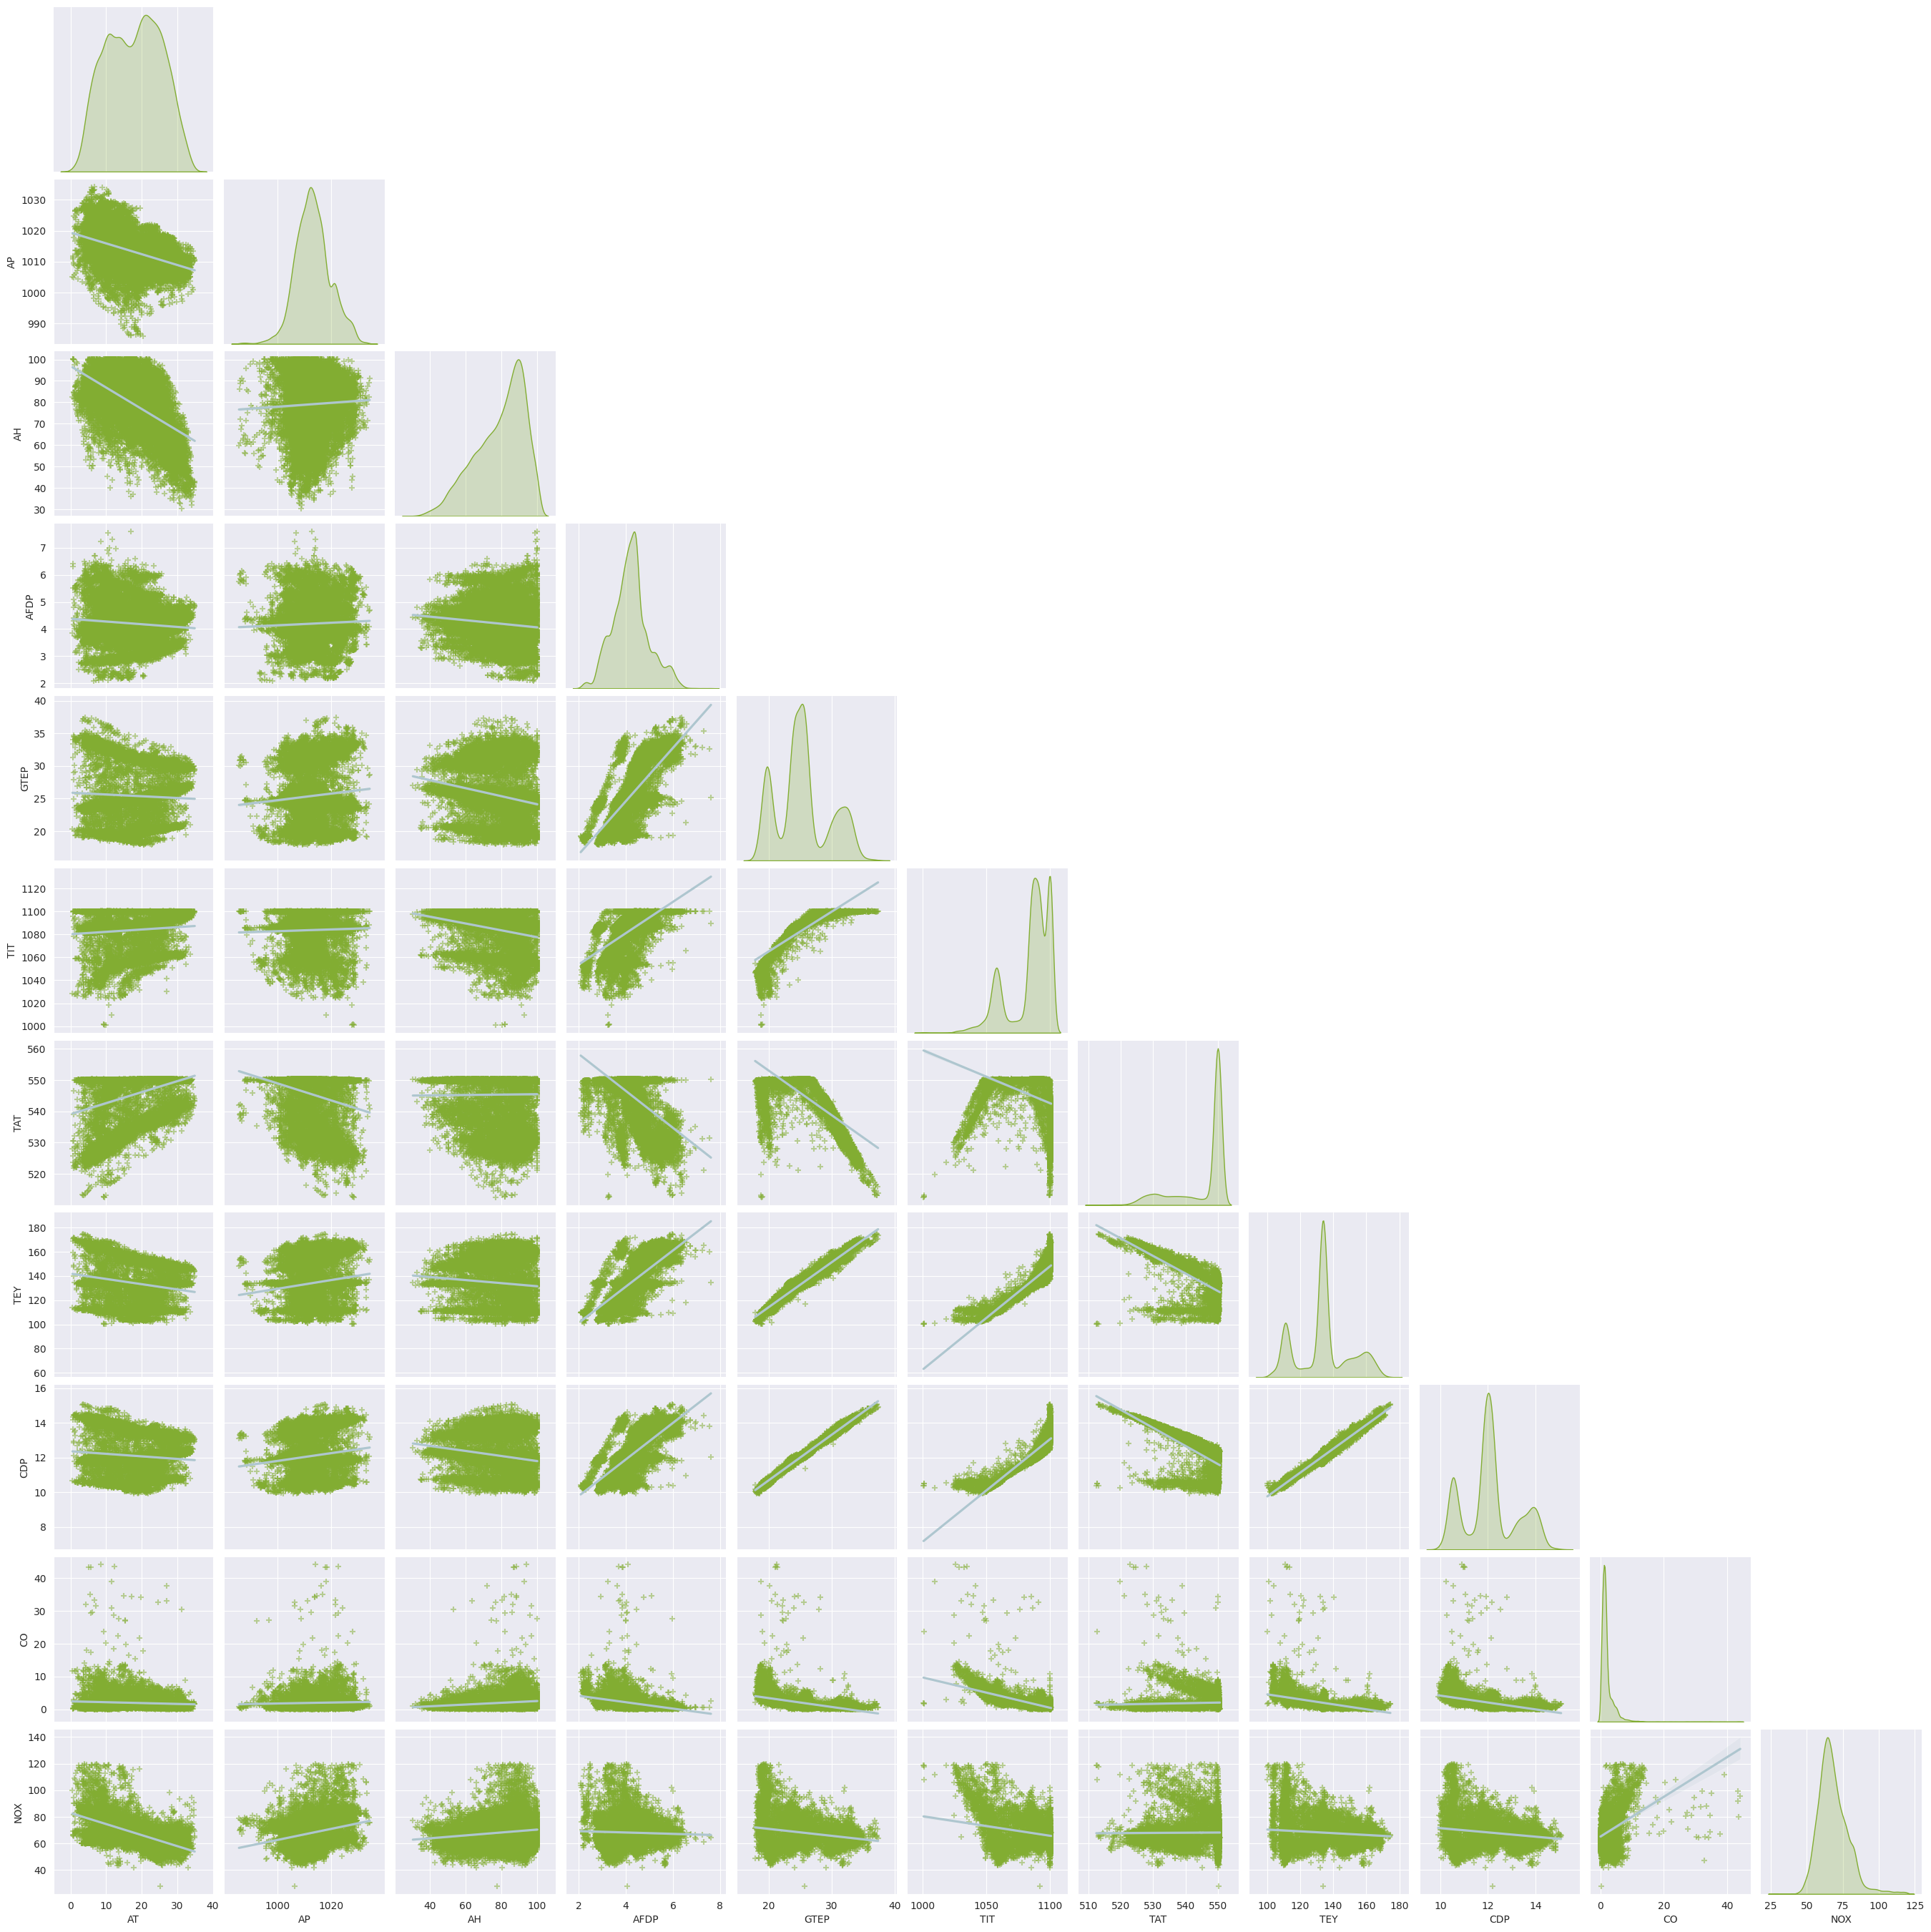

In [18]:
plt.figure(figsize=(20,20))
sns.pairplot(df,
                 markers="+",
                 kind='reg',
                 diag_kind="kde",
                 plot_kws={'line_kws':{'color':'#aec6cf'},
                           'scatter_kws': {'alpha': 0.5,
                                           'color': '#82ad32'}},
               corner=True,
                 diag_kws= {'color': '#82ad32'})

In [19]:
x = df.drop('TEY', axis=1)
y = df[["TEY"]]

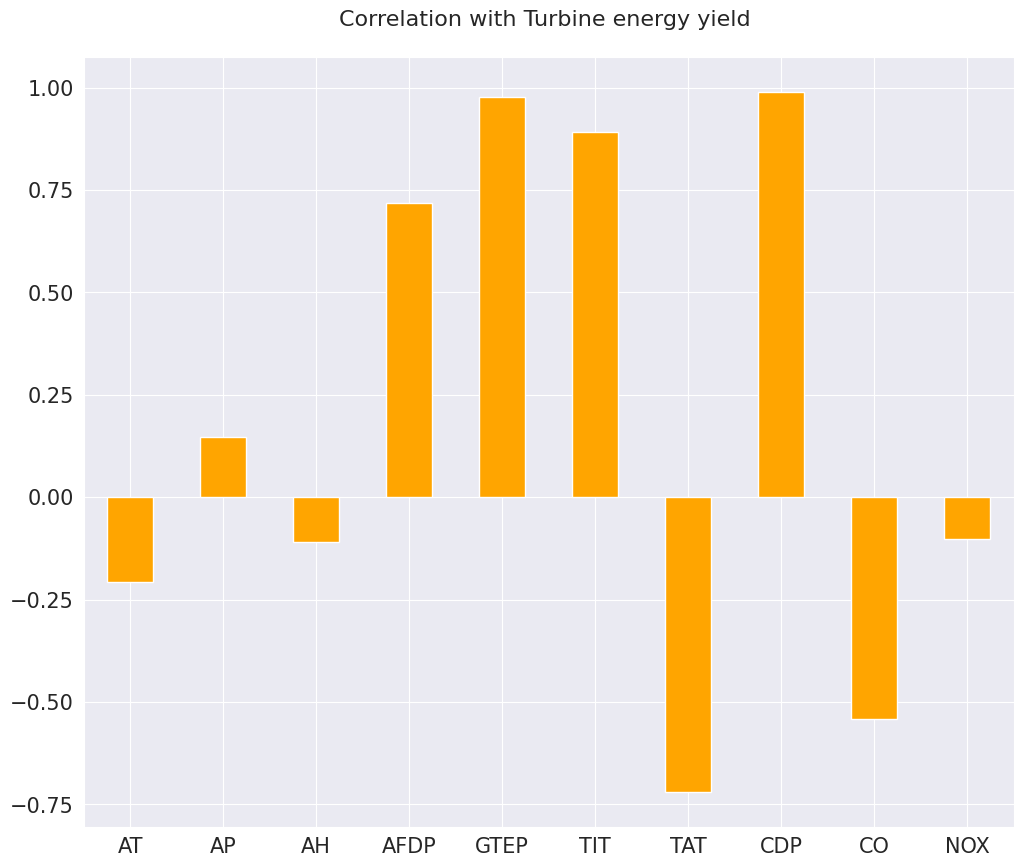

In [20]:
data2 = df.copy()

correlations = data2.corrwith(df.TEY)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations>0].sort_values(ascending = False)
negative_correlations = correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(figsize=(12,10), fontsize = 15, color = 'orange', rot = 0, grid = True)
plt.title('Correlation with Turbine energy yield \n', fontsize = "16", fontfamily = "sans-serif")
plt.show()

# Data Pre-Processing

### Feature Selection Technique

In [21]:
from numpy import set_printoptions
from sklearn.feature_selection import mutual_info_regression

### Feature Extraction

In [22]:
x.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,10.612,3.2484,82.311


In [23]:
x.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
CDP     0
CO      0
NOX     0
dtype: int64

In [24]:
y.head()

,TEY
0,114.70
1,114.72
2,114.71
3,114.72
4,114.72


In [25]:
test = SelectKBest(score_func=mutual_info_regression, k='all')
fit = test.fit(x,y)

In [26]:
# Summarize Scores
scores = fit.scores_
features = fit.transform(x)

In [27]:
score_df = pd.DataFrame(list(zip(scores, x.columns)), columns =['Score', 'Feature'])
score_df.sort_values(by="Score", ascending=False, inplace=True)
score_df

,Score,Feature
7,1.712609,CDP
4,1.600444,GTEP
5,1.324387,TIT
6,0.894411,TAT
3,0.660611,AFDP
8,0.512575,CO
0,0.412569,AT
9,0.300473,NOX
1,0.139844,AP
2,0.098005,AH


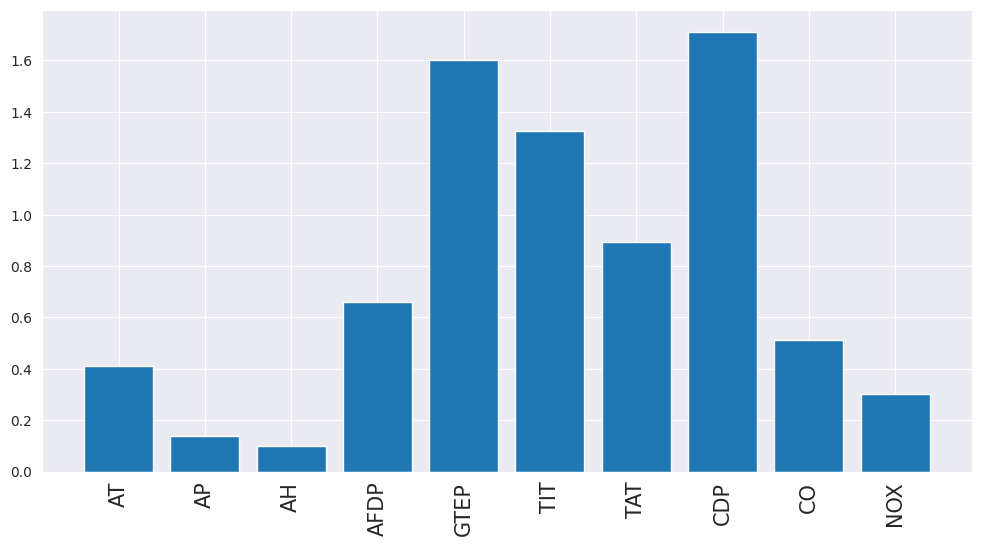

In [28]:
fig, axes = plt.subplots(figsize=(12,6))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8,9])
axes.set_xticklabels(x.columns.values)
plt.xticks(rotation = 90, size = 15)
plt.show()

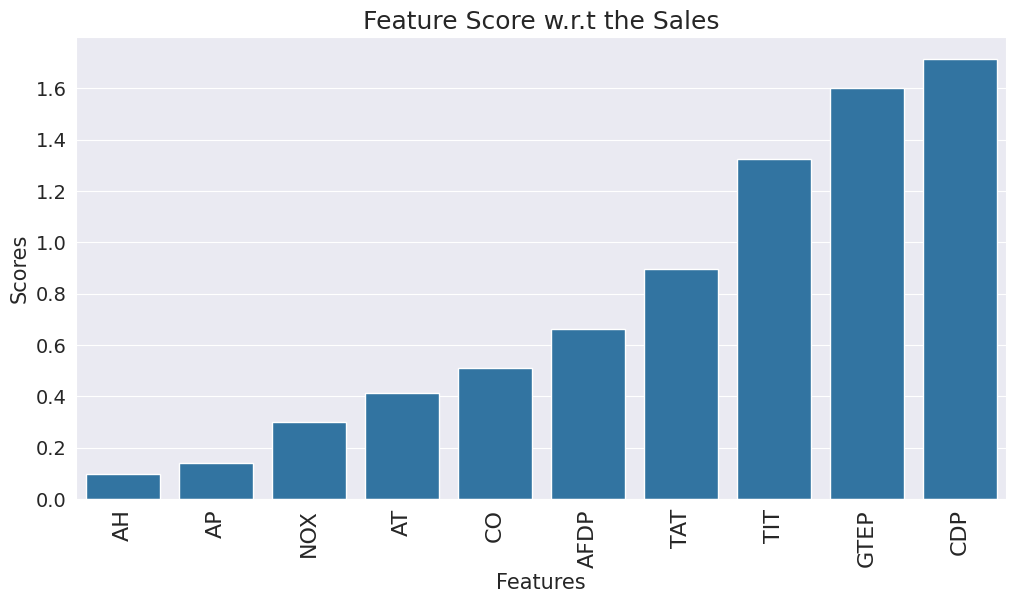

In [29]:
plt.figure(figsize=(12,6))
sns.barplot(x='Feature', y="Score", data=score_df, order=score_df.sort_values('Score').Feature)
plt.xlabel("Features", size=15)
plt.ylabel("Scores", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Score w.r.t the Sales", size=18)
plt.show()

In [30]:
score_df.sort_values('Score', ascending=False)

,Score,Feature
7,1.712609,CDP
4,1.600444,GTEP
5,1.324387,TIT
6,0.894411,TAT
3,0.660611,AFDP
8,0.512575,CO
0,0.412569,AT
9,0.300473,NOX
1,0.139844,AP
2,0.098005,AH


In [31]:
model_data = df[['CDP', 'GTEP','TIT', 'TAT', 'AFDP', 'CO', 'AT',"TEY"]]
model_data.head()

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,10.605,19.663,1059.2,550.00,3.5000,3.1547,6.8594,114.70
1,10.598,19.728,1059.3,550.00,3.4998,3.2363,6.7850,114.72
2,10.601,19.779,1059.4,549.87,3.4824,3.2012,6.8977,114.71
3,10.606,19.792,1059.6,549.99,3.4805,3.1923,7.0569,114.72
4,10.612,19.765,1059.7,549.98,3.4976,3.2484,7.3978,114.72


# Feature Engineering

In [32]:
# Applying Standard Scaler
continuous_feature=[feature for feature in model_data.columns if model_data[feature].dtype!='O']
print('Continuous Feature Count {}'.format(len(continuous_feature)))

Continuous Feature Count 8


In [33]:
df_standard_scaled = model_data.copy()
features = df_standard_scaled[continuous_feature]

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_standard_scaled[continuous_feature] = scaler.fit_transform(features.values)
df_standard_scaled.head()

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,-1.357331,-1.379101,-1.488376,0.585240,-0.921232,0.532012,-1.439778,-1.231172
1,-1.363676,-1.363528,-1.482325,0.585240,-0.921495,0.568733,-1.449601,-1.229909
2,-1.360957,-1.351309,-1.476275,0.568715,-0.944385,0.552938,-1.434721,-1.230541
3,-1.356424,-1.348194,-1.464173,0.583969,-0.946884,0.548933,-1.413702,-1.229909
4,-1.350985,-1.354663,-1.458123,0.582698,-0.924389,0.574179,-1.368693,-1.229909


In [35]:
print('Mean' '\n',np.round(df_standard_scaled.mean(),1))

Mean
 CDP     0.0
GTEP   -0.0
TIT    -0.0
TAT     0.0
AFDP    0.0
CO      0.0
AT      0.0
TEY     0.0
dtype: float64


In [36]:
print('Standard Devaition','\n',np.round(df_standard_scaled.std(),1))

Standard Devaition 
 CDP     1.0
GTEP    1.0
TIT     1.0
TAT     1.0
AFDP    1.0
CO      1.0
AT      1.0
TEY     1.0
dtype: float64


# Test Train Split With Imbalanced Dataset

In [37]:
x = df_standard_scaled.drop('TEY',axis=1)
y = df_standard_scaled[['TEY']]

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)

# Hyperparameter Tuning

### Hyperparameter Tuning: Optimal Learning rate ,Number of Layers and Neurons

In [39]:
def build_model(hp):
    model =Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units = hp.Int('units_' + str(i), min_value=32, max_value=100, step=32), activation='relu'))

    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error', metrics=['mean_absolute_error'])
    return model

In [40]:
from keras_tuner.tuners import RandomSearch

In [41]:
tuner = RandomSearch(build_model, objective= 'val_mean_absolute_error', max_trials= 5,
                     executions_per_trial= 3, directory= 'project', project_name= 'Gas Turbine')
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [42]:
tuner.search(x_train, y_train,epochs=100,validation_data=(x_test, y_test))

Trial 5 Complete [00h 11m 19s]
val_mean_absolute_error: 0.25886120709280175

Best val_mean_absolute_error So Far: 0.02414741242925326
Total elapsed time: 00h 50m 53s


In [43]:
tuner.results_summary()

Results summary
Results in project/Gas Turbine
Showing 10 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 1 summary
Hyperparameters:
num_layers: 13
units_0: 96
units_1: 96
learning_rate: 0.0001
units_2: 96
units_3: 32
units_4: 64
units_5: 96
units_6: 32
units_7: 32
units_8: 96
units_9: 64
units_10: 96
units_11: 96
units_12: 32
Score: 0.02414741242925326

Trial 3 summary
Hyperparameters:
num_layers: 16
units_0: 96
units_1: 64
learning_rate: 0.001
units_2: 32
units_3: 32
units_4: 96
units_5: 32
units_6: 32
units_7: 96
units_8: 64
units_9: 64
units_10: 96
units_11: 32
units_12: 32
units_13: 32
units_14: 32
units_15: 32
Score: 0.02443321670095126

Trial 2 summary
Hyperparameters:
num_layers: 3
units_0: 96
units_1: 32
learning_rate: 0.01
units_2: 32
units_3: 32
units_4: 64
units_5: 96
units_6: 96
units_7: 96
units_8: 32
units_9: 64
units_10: 96
units_11: 32
units_12: 32
Score: 0.026578158140182495

Trial 0 summary
Hyperparameters:
num_layers: 12
units_0: 96
uni

### Hyperparameter Tuning: Optimal Batch_size, Number of Epochs

In [44]:
def create_model():
    model1 = Sequential()
    model1.add(Dense(32,input_dim=7,activation='relu'))
    model1.add(Dense(64,activation='relu'))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(units=1,activation="linear"))

    adam=Adam(learning_rate=0.001)
    model1.compile(loss= 'mean_absolute_error', optimizer= adam, metrics= ["mean_absolute_error"])
    return model1

In [45]:
model1     = KerasRegressor(build_fn=create_model,verbose=0)
batch_size = [20,40,50]
epochs     = [50,100,200]
param_grid = dict(batch_size= batch_size, epochs= epochs)
grid = GridSearchCV(estimator= model1, param_grid= param_grid, cv= KFold(), verbose= 10)

In [46]:
grid_result1 = grid.fit(x_test,y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START batch_size=20, epochs=50....................................
[CV 1/5; 1/9] END ....batch_size=20, epochs=50;, score=-0.034 total time=  23.0s
[CV 2/5; 1/9] START batch_size=20, epochs=50....................................
[CV 2/5; 1/9] END ....batch_size=20, epochs=50;, score=-0.031 total time=  21.4s
[CV 3/5; 1/9] START batch_size=20, epochs=50....................................
[CV 3/5; 1/9] END ....batch_size=20, epochs=50;, score=-0.031 total time=  42.6s
[CV 4/5; 1/9] START batch_size=20, epochs=50....................................
[CV 4/5; 1/9] END ....batch_size=20, epochs=50;, score=-0.029 total time=  42.3s
[CV 5/5; 1/9] START batch_size=20, epochs=50....................................
[CV 5/5; 1/9] END ....batch_size=20, epochs=50;, score=-0.030 total time=  21.3s
[CV 1/5; 2/9] START batch_size=20, epochs=100...................................
[CV 1/5; 2/9] END ...batch_size=20, epochs=100;, 

In [47]:
print('Best {}, using {}'.format(grid_result1.best_score_, grid_result1.best_params_))
means  = grid_result1.cv_results_["mean_test_score"]
stds   = grid_result1.cv_results_["std_test_score"]
params = grid_result1.cv_results_["params"]
for mean,stdev,param in zip(means, stds,params):
    print("{}, {} with {}".format(mean, stdev, param))

Best -0.028477631881833075, using {'batch_size': 50, 'epochs': 200}
-0.03107554018497467, 0.0016281796315592613 with {'batch_size': 20, 'epochs': 50}
-0.029628944769501685, 0.0018147226513082033 with {'batch_size': 20, 'epochs': 100}
-0.0320419579744339, 0.0036046347041528695 with {'batch_size': 20, 'epochs': 200}
-0.033680734038352964, 0.005214585701833855 with {'batch_size': 40, 'epochs': 50}
-0.02992372214794159, 0.0012703438124905726 with {'batch_size': 40, 'epochs': 100}
-0.02881285659968853, 0.0022198838317876095 with {'batch_size': 40, 'epochs': 200}
-0.03185976929962635, 0.00449490928027766 with {'batch_size': 50, 'epochs': 50}
-0.030851465463638306, 0.002314153802046185 with {'batch_size': 50, 'epochs': 100}
-0.028477631881833075, 0.003382663114678698 with {'batch_size': 50, 'epochs': 200}


### Hyperparameter Tuning: Optimal Droupout rate

In [48]:
def create_model(dropout_rate):
    model2 = Sequential()
    model2.add(Dense(32,input_dim=7,activation='relu'))
    model2.add(Dense(64,activation='relu'))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(units=1,activation="linear"))

    adam = Adam(lr=0.001)
    model2.compile(loss= 'mean_absolute_error', optimizer= adam, metrics= ["mean_absolute_error"])
    return model2

In [49]:
model2       = KerasRegressor(build_fn= create_model, batch_size= 40, epochs= 200, verbose= 0)
dropout_rate = [0.0,0.1,0.2,0.3,0.4,0.5]
param_grid   = dict(dropout_rate= dropout_rate)
grid2        = GridSearchCV(estimator= model2, param_grid= param_grid, cv= KFold(), verbose= 10)

In [50]:
grid_result2 = grid2.fit(x_test, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START dropout_rate=0.0............................................
[CV 1/5; 1/6] END ............dropout_rate=0.0;, score=-0.030 total time=  45.4s
[CV 2/5; 1/6] START dropout_rate=0.0............................................
[CV 2/5; 1/6] END ............dropout_rate=0.0;, score=-0.027 total time=  47.3s
[CV 3/5; 1/6] START dropout_rate=0.0............................................
[CV 3/5; 1/6] END ............dropout_rate=0.0;, score=-0.027 total time=  46.7s
[CV 4/5; 1/6] START dropout_rate=0.0............................................
[CV 4/5; 1/6] END ............dropout_rate=0.0;, score=-0.028 total time= 1.4min
[CV 5/5; 1/6] START dropout_rate=0.0............................................
[CV 5/5; 1/6] END ............dropout_rate=0.0;, score=-0.032 total time=  45.7s
[CV 1/5; 2/6] START dropout_rate=0.1............................................
[CV 1/5; 2/6] END ............dropout_rate=0.1;, 

In [51]:
print('Best {}, using {}'.format(grid_result2.best_score_, grid_result2.best_params_))
means = grid_result2.cv_results_["mean_test_score"]
stds  = grid_result2.cv_results_["std_test_score"]
params = grid_result2.cv_results_["params"]
for mean,stdev,param in zip(means, stds, params):
    print("{}, {} with {}".format(mean, stdev, param))

Best -0.028605133295059204, using {'dropout_rate': 0.3}
-0.028764516487717627, 0.0018071105135468812 with {'dropout_rate': 0.0}
-0.03038189709186554, 0.0020266898253229098 with {'dropout_rate': 0.1}
-0.029097694158554076, 0.0021304689190676145 with {'dropout_rate': 0.2}
-0.028605133295059204, 0.0028143140354217056 with {'dropout_rate': 0.3}
-0.0317489318549633, 0.0069823347671589065 with {'dropout_rate': 0.4}
-0.029007694125175475, 0.0007572262737266113 with {'dropout_rate': 0.5}


### Hyperparameter Tuning: Optimal Activation Function and Kernel Initializer

In [52]:
def create_model(activation_function,init):
    model3 = Sequential()
    model3.add(Dense(32,input_dim=7,activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(units=1,activation="linear"))

    adam = Adam(lr=0.001)
    model3.compile(loss= 'mean_absolute_error', optimizer= adam, metrics= ["mean_absolute_error"])
    return model3

In [53]:
model3 = KerasRegressor(build_fn=create_model, batch_size=40,epochs=200,verbose=0)
activation_function = ['softmax','tanh','relu']
init = ['normal','uniform','zero']
param_grid = dict(activation_function= activation_function, init= init)
grid3 = GridSearchCV(estimator= model3, param_grid= param_grid, cv= KFold(), verbose=10)

In [54]:
grid_result3 = grid3.fit(x_test,y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START activation_function=softmax, init=normal....................
[CV 1/5; 1/9] END activation_function=softmax, init=normal;, score=-0.498 total time= 1.0min
[CV 2/5; 1/9] START activation_function=softmax, init=normal....................
[CV 2/5; 1/9] END activation_function=softmax, init=normal;, score=-0.184 total time= 1.0min
[CV 3/5; 1/9] START activation_function=softmax, init=normal....................
[CV 3/5; 1/9] END activation_function=softmax, init=normal;, score=-0.502 total time= 1.1min
[CV 4/5; 1/9] START activation_function=softmax, init=normal....................
[CV 4/5; 1/9] END activation_function=softmax, init=normal;, score=-0.169 total time= 1.4min
[CV 5/5; 1/9] START activation_function=softmax, init=normal....................
[CV 5/5; 1/9] END activation_function=softmax, init=normal;, score=-0.486 total time= 1.1min
[CV 1/5; 2/9] START activation_function=softmax, init=uniform.........

In [55]:
print('Best {}, using {}'.format(grid_result3.best_score_, grid_result3.best_params_))
means = grid_result3.cv_results_["mean_test_score"]
stds  = grid_result3.cv_results_["std_test_score"]
params = grid_result3.cv_results_["params"]
for mean,stdev,param in zip(means, stds, params):
    print("{}, {} with {}".format(mean, stdev, param))

Best -0.3379839688539505, using {'activation_function': 'tanh', 'init': 'zero'}
-0.36776707470417025, 0.15653647449178715 with {'activation_function': 'softmax', 'init': 'normal'}
-0.3812019437551498, 0.17602326526708106 with {'activation_function': 'softmax', 'init': 'uniform'}
-0.4065486520528793, 0.1898490046469668 with {'activation_function': 'softmax', 'init': 'zero'}
-0.5142734169960022, 0.2158271982962801 with {'activation_function': 'tanh', 'init': 'normal'}
-0.5622954428195953, 0.12721140876358233 with {'activation_function': 'tanh', 'init': 'uniform'}
-0.3379839688539505, 0.11699227028440469 with {'activation_function': 'tanh', 'init': 'zero'}
-0.4038438946008682, 0.13357881465320745 with {'activation_function': 'relu', 'init': 'normal'}
-0.39958145618438723, 0.18801674805278623 with {'activation_function': 'relu', 'init': 'uniform'}
-0.43964617848396303, 0.20104640873970536 with {'activation_function': 'relu', 'init': 'zero'}


# Model Building Neural Networks

In [56]:
# Standardizing only predictor variable - after train test split
model_data

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,10.605,19.663,1059.2,550.00,3.5000,3.1547,6.8594,114.70
1,10.598,19.728,1059.3,550.00,3.4998,3.2363,6.7850,114.72
2,10.601,19.779,1059.4,549.87,3.4824,3.2012,6.8977,114.71
3,10.606,19.792,1059.6,549.99,3.4805,3.1923,7.0569,114.72
4,10.612,19.765,1059.7,549.98,3.4976,3.2484,7.3978,114.72
...,...,...,...,...,...,...,...,...
15034,10.400,19.164,1049.7,546.21,3.5421,4.5186,9.0301,111.61
15035,10.433,19.414,1046.3,543.22,3.5059,4.8470,7.8879,111.78
15036,10.483,19.530,1037.7,537.32,3.4770,7.9632,7.2647,110.19
15037,10.533,19.377,1043.2,541.24,3.4486,6.2494,7.0060,110.74


In [57]:
# Assigning predictor variables to x and response variable to y
x = model_data.drop('TEY', axis=1)
y = model_data[["TEY"]]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state=42)

scaler_train = StandardScaler()
scaler_test = StandardScaler()

x_train_scaled = scaler_train.fit_transform(x_train) # scaling train data -- predictor
x_test_scaled  = scaler_test.fit_transform(x_test)   # scaling test data -- predictor

print("x_train_scaled :", x_train_scaled.shape)
print("x_test_scaled  :",x_test_scaled.shape)
print("y_train        :",y_train.shape)
print("y_test         :",y_test.shape)

x_train_scaled : (12031, 7)
x_test_scaled  : (3008, 7)
y_train        : (12031, 1)
y_test         : (3008, 1)


In [58]:
# Since we have continuous ouput, AF is not required in the o/p layer
model = Sequential()
model.add( Dense(units= 50, activation= 'relu', kernel_initializer= 'normal', input_dim= 7)) # input layer
model.add( Dense(units= 20, activation= 'tanh', kernel_initializer= 'normal')) # hidden layer
model.add( Dense(units= 1, kernel_initializer= 'normal' )) # o/p layer

model.compile(optimizer= "adam", loss= "mse", metrics= ["mae", "mse"])
history = model.fit(x_train_scaled, y_train, batch_size= 50, validation_split= 0.3, epochs=10,  verbose=1)

Epoch 1/10
169/169 [==============================] - 1s 4ms/step - loss: 17619.7480 - mae: 131.7815 - mse: 17619.7480 - val_loss: 16768.9180 - val_mae: 128.5341 - val_mse: 16768.9180
Epoch 2/10
169/169 [==============================] - 0s 3ms/step - loss: 16272.7354 - mae: 126.5695 - mse: 16272.7354 - val_loss: 15716.5918 - val_mae: 124.3729 - val_mse: 15716.5908
Epoch 3/10
169/169 [==============================] - 1s 3ms/step - loss: 15298.2363 - mae: 122.6597 - mse: 15298.2363 - val_loss: 14799.0840 - val_mae: 120.6280 - val_mse: 14799.0840
Epoch 4/10
169/169 [==============================] - 1s 3ms/step - loss: 14414.6348 - mae: 119.0048 - mse: 14414.6348 - val_loss: 13947.4590 - val_mae: 117.0448 - val_mse: 13947.4590
Epoch 5/10
169/169 [==============================] - 1s 3ms/step - loss: 13586.6914 - mae: 115.4725 - mse: 13586.6914 - val_loss: 13144.3574 - val_mae: 113.5623 - val_mse: 13144.3574
Epoch 6/10
169/169 [==============================] - 0s 3ms/step - loss: 12802.

In [59]:
def toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test):

    # Defining list of hyperparameters
    batch_size_list = [10 , 15 , 20 ]
    epoch_list      = [10 , 50 , 100]

    bestParamTable = pd.DataFrame()

    for batch_trial in batch_size_list:
        for epochs_trial in epoch_list:

            # Create ANN model
            model = Sequential()

            # Defining the first layer of the model
            model.add(Dense(units=50, input_dim=x_train_scaled.shape[1], kernel_initializer='normal', activation='relu'))

            # Defining the Second layer of the model
            model.add(Dense(units=20, kernel_initializer='normal', activation='tanh'))

            # The output neuron is a single fully connected node Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))

            # Compiling the model
            model.compile(optimizer ='adam', loss = 'mean_squared_error')

            # Fitting the ANN to the Training set
            model.fit(x_train_scaled, y_train , batch_size=batch_trial, epochs=epochs_trial,  verbose=0)

            MAPE = np.mean(100 * (np.abs(y_test-model.predict(x_test_scaled))/y_test))

            bestParamTable=bestParamTable.append(pd.DataFrame(data=[[batch_trial, epochs_trial, 100-MAPE]], columns=['batchsize','epochs','Accuracy'] ))

            # Printing the results of the current iteration
            print('batch_size:', batch_trial,'-', 'epochs:', epochs_trial, 'Accuracy:', 100-MAPE)

    return bestParamTable
    # Calling the function
finalParamTable = toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test)

94/94 [==============================] - 0s 1ms/step
batch_size: 10 - epochs: 10 Accuracy: TEY    98.216771
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 10 - epochs: 50 Accuracy: TEY    99.638245
dtype: float64
94/94 [==============================] - 0s 2ms/step
batch_size: 10 - epochs: 100 Accuracy: TEY    99.700605
dtype: float64
94/94 [==============================] - 0s 2ms/step
batch_size: 15 - epochs: 10 Accuracy: TEY    89.839813
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 15 - epochs: 50 Accuracy: TEY    99.577479
dtype: float64
94/94 [==============================] - 0s 2ms/step
batch_size: 15 - epochs: 100 Accuracy: TEY    99.58859
dtype: float64
94/94 [==============================] - 0s 2ms/step
batch_size: 20 - epochs: 10 Accuracy: TEY    80.9751
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 20 - epochs: 50 Accuracy: TEY    99.616186
dtype: float64
94/94 [==========

In [60]:
# Training Model - using best params
model.compile(optimizer ='adam', loss = 'mean_squared_error')
model.fit(x_train_scaled,y_train, batch_size= 20, epochs= 10, verbose= 0)

# Model Evaluation Train and Test Error

### Predicting values from Model using same dataset

In [61]:
# generating predictions for test data
y_predict_test = model.predict(x_test_scaled)

# creating table with test price & predicted price for test
predictions_df = pd.DataFrame(x_test)
predictions_df['Actual'] = y_test
predictions_df['Predicted'] = y_predict_test
print(predictions_df.shape)
predictions_df.head(10)

94/94 [==============================] - 0s 1ms/step
(3008, 9)


,CDP,GTEP,TIT,TAT,AFDP,CO,AT,Actual,Predicted
13312,12.219,25.762,1092.5,550.25,4.0023,1.26430,24.0930,134.46,127.221558
12627,10.791,20.085,1059.6,549.94,3.2106,2.69370,20.4500,111.88,127.221558
6393,12.126,25.221,1089.9,549.62,4.5325,1.96250,20.2620,133.72,127.221558
4990,12.218,25.965,1092.9,549.96,4.4266,1.57120,26.8620,133.79,127.221558
12462,10.466,19.688,1056.9,550.01,3.1241,2.29960,19.4090,110.77,127.221558
7405,10.624,19.387,1058.9,550.17,3.3709,4.27640,2.2158,113.32,127.221558
10993,12.088,25.392,1089.7,550.11,3.7871,0.83578,23.8520,133.77,127.221558
9488,11.498,23.225,1079.4,549.60,4.2837,2.01980,12.3950,128.98,127.221558
14201,13.971,32.518,1100.1,528.98,5.1559,0.87760,12.3590,159.42,127.221558
9757,13.862,32.105,1100.0,530.69,5.9309,10.75000,8.6376,161.86,127.221558


In [62]:
predictions_df.drop(['CDP','GTEP','TIT','TAT','AFDP','CO','AT'], axis= 1 , inplace= True)

# Calculating Absolute Percent Error and Error

In [63]:
# Computing the absolute percent error
APE = 100*(abs(predictions_df['Actual']-predictions_df['Predicted'])/predictions_df['Actual'])
print('The Accuracy for Test Data -- ANN model = ', 100-np.mean(APE))

# adding absolute percent error to table
predictions_df['APE %'] = APE
predictions_df.head()

The Accuracy for Test Data -- ANN model =  89.73157513751609


,Actual,Predicted,APE %
13312,134.46,127.221558,5.383343
12627,111.88,127.221558,13.712511
6393,133.72,127.221558,4.859739
4990,133.79,127.221558,4.909517
12462,110.77,127.221558,14.851997


In [64]:
predictions_df['Error'] = (predictions_df['Actual'] - predictions_df['Predicted'])/(predictions_df['Actual'])
predictions_df.reset_index(drop = True)

,Actual,Predicted,APE %,Error
0,134.46,127.221558,5.383343,0.053833
1,111.88,127.221558,13.712511,-0.137125
2,133.72,127.221558,4.859739,0.048597
3,133.79,127.221558,4.909517,0.049095
4,110.77,127.221558,14.851997,-0.148520
...,...,...,...,...
3003,119.25,127.221558,6.684744,-0.066847
3004,133.74,127.221558,4.873966,0.048740
3005,146.31,127.221558,13.046574,0.130466
3006,150.07,127.221558,15.225190,0.152252


# Visualizing the Relationship between the Actual and Predicted ValuesModel Validation

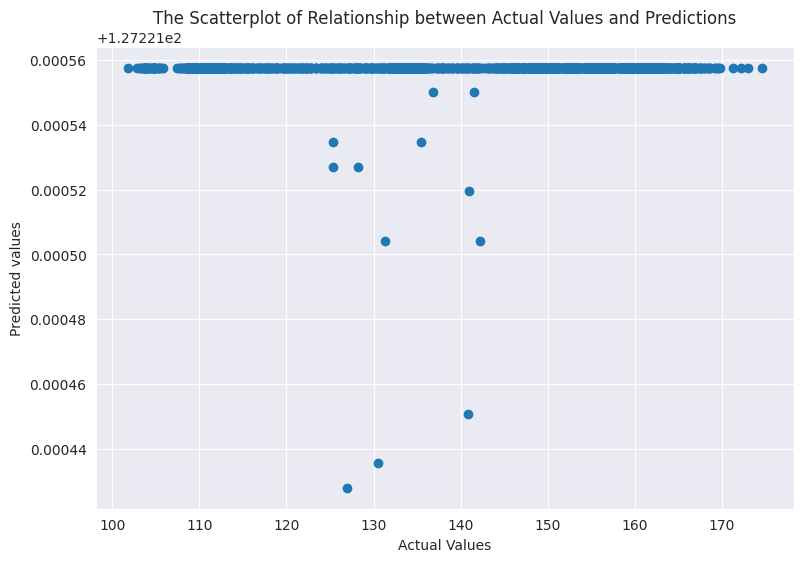

In [65]:
plt.figure(figsize=(9,6))
plt.xlabel("Actual Values")
plt.ylabel("Predicted values")
plt.title("The Scatterplot of Relationship between Actual Values and Predictions")
plt.scatter(predictions_df['Actual'], predictions_df['Predicted'])

### We will evaluate our model performance by calculating the residual sum of squares and the explained variance score

In [66]:
from sklearn import metrics
print("MAE  :",metrics.mean_absolute_error(y_test,y_predict_test))
print("MSE  :",metrics.mean_squared_error(y_test,y_predict_test))
print("RMSE :",np.sqrt(metrics.mean_squared_error(y_test,y_predict_test)))

MAE  : 14.038985240408714
MSE  : 295.7152125922856
RMSE : 17.196372076466755


In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_predict_test = model.predict(x_test_scaled)
y_predict_train = model.predict(x_train_scaled)
print('R2_score (train) : ',r2_score(y_train, y_predict_train))
print('R2_score (test)  : ',r2_score(y_test, y_predict_test))

376/376 [==============================] - 1s 2ms/step
R2_score (train) :  -0.19696787449418807
R2_score (test)  :  -0.1810202646690866


# Evaluation of the explained variance score (R^2)

In [68]:
print('This shows our model predict % {} of the target correctly'.format(np.round(metrics.explained_variance_score(y_test,y_predict_test)*100,2)))

This shows our model predict % 0.0 of the target correctly


# Residual Analysis

### Test for Normality of Residuals (Q-Q Plot)

<Axes: ylabel='Density'>

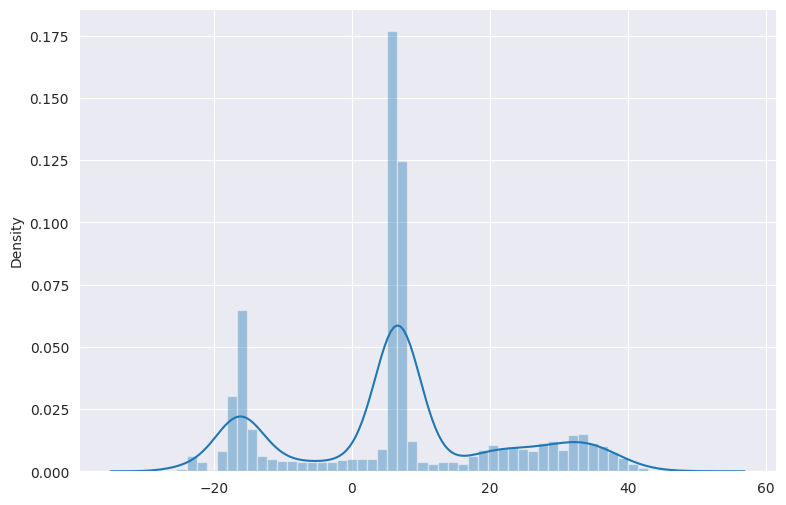

In [69]:
# Now we will visualize the differences between our predictions and actual y test data
plt.figure(figsize=(9,6))
sns.distplot(y_test-y_predict_test,bins=50) # this figure also proves that our model fits very good

### There is no huge differences between our predictions and actual y data

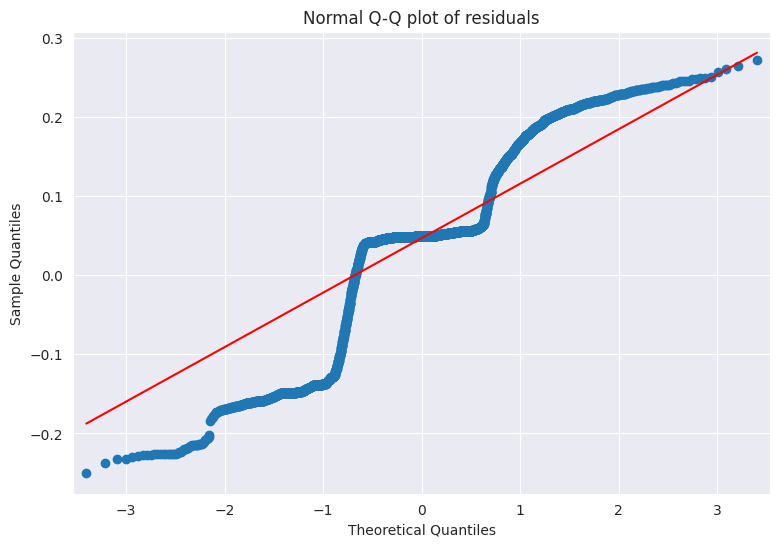

In [70]:
import statsmodels.api as smf
plt.rcParams["figure.figsize"] = (9,6)
smf.qqplot(predictions_df['Error'], line= 'q')
plt.title('Normal Q-Q plot of residuals')
plt.show()

### Error should have Normal / Gaussian distribution~N(0,1) and independently and identically distributed.